<a href="https://colab.research.google.com/github/trong-khanh-1109/CS231.M13.KHCL/blob/main/Garbage_Classification_GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd '/content'
!gdown https://drive.google.com/uc?id=1C8BEEW_Lw4AUj4tHYNEjKaJIA6nnqYS3 # old
# !gdown https://drive.google.com/uc?id=1cexqei_xiWRnw6ne0vyYK5g7LFlc2kbn #new

/content
Downloading...
From: https://drive.google.com/uc?id=1C8BEEW_Lw4AUj4tHYNEjKaJIA6nnqYS3
To: /content/Garbage classification 1.zip
100% 56.7M/56.7M [00:00<00:00, 181MB/s] 


In [ ]:
!unzip '/content/Garbage classification 1.zip'

In [ ]:
from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


# Import library

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from keras.layers.merge import concatenate
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
FJoin = os.path.join

# Data preprocessing

In [ ]:
path = '/content/Garbage classification'

In [ ]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20, # Dữ liệu được tạo ra sẽ được xoay ngẫu nhiên một góc trong phạm vi +rotation_rangeđến -rotation_range(tính bằng độ)
        width_shift_range = 0.2, # Dịch theo chiều ngang ngẫu nhiên trong một phạm vi nào đó
        height_shift_range = 0.2, # Dịch ảnh theo chiều dọc trong một phạm vi nào đó
        horizontal_flip = True, # lật ảnh ngẫu nhiên theo chiều ngang
        vertical_flip = True, # lật ảnh ngẫu nhiên theo chiều dọc
)

validation_datagen = ImageDataGenerator(
        rescale = 1./255
)

test_datagen = ImageDataGenerator(
        rescale = 1./255
)

In [ ]:
img_shape = (224, 224, 3)
train_batch_size = 16
val_batch_size = 16

train_generator = train_datagen.flow_from_directory(
            path + '/train',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = train_batch_size,
            class_mode = 'categorical',)

validation_generator = validation_datagen.flow_from_directory(
            path + '/validation',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False)

test_generator = test_datagen.flow_from_directory(
            path + '/test',
            target_size = (img_shape[0], img_shape[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle=False,)

Found 2880 images belonging to 6 classes.
Found 960 images belonging to 6 classes.
Found 961 images belonging to 6 classes.


# Build the model

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(6, activation = 'softmax', name = 'extra1')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(6, activation = 'softmax', name = 'extra2')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)
  
  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(6, activation = 'softmax', name='main')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [ ]:
# create model
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(units=256, activation='linear',kernel_regularizer=regularizers.l2(0.0001))(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model

In [ ]:
CLASS_NUM = 6
EPOCH_STEPS = train_generator.samples/train_batch_size # 2880 / 16
IMAGE_SHAPE = (224, 224, 3)

In [ ]:
model = GoogLeNet()
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_68 (Conv2D)             (None, 109, 109, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_16 (MaxPooling2D  (None, 54, 54, 64)  0           ['conv2d_68[0][0]']              
 )                                                                                        

In [ ]:
index = 1
for layer in model.layers:
  print("----layer " + str(index))
  print(layer)
  index = index + 1

----layer 1
----layer 2
----layer 3
----layer 4
----layer 5
----layer 6
----layer 7
----layer 8
----layer 9
----layer 10
----layer 11
----layer 12
----layer 13
----layer 14
----layer 15
----layer 16
----layer 17
----layer 18
----layer 19
----layer 20
----layer 21
----layer 22
----layer 23
----layer 24
----layer 25
----layer 26
----layer 27
----layer 28
----layer 29
----layer 30
----layer 31
----layer 32
----layer 33
----layer 34
----layer 35
----layer 36
----layer 37
----layer 38
----layer 39
----layer 40
----layer 41
----layer 42
----layer 43
----layer 44
----layer 45
----layer 46
----layer 47
----layer 48
----layer 49
----layer 50
----layer 51
----layer 52
----layer 53
----layer 54
----layer 55
----layer 56
----layer 57
----layer 58
----layer 59
----layer 60
----layer 61
----layer 62
----layer 63
----layer 64
----layer 65
----layer 66
----layer 67
----layer 68
----layer 69
----layer 70
----layer 71
----layer 72
----layer 73
----layer 74
----layer 75
----layer 76
----layer 77
----laye

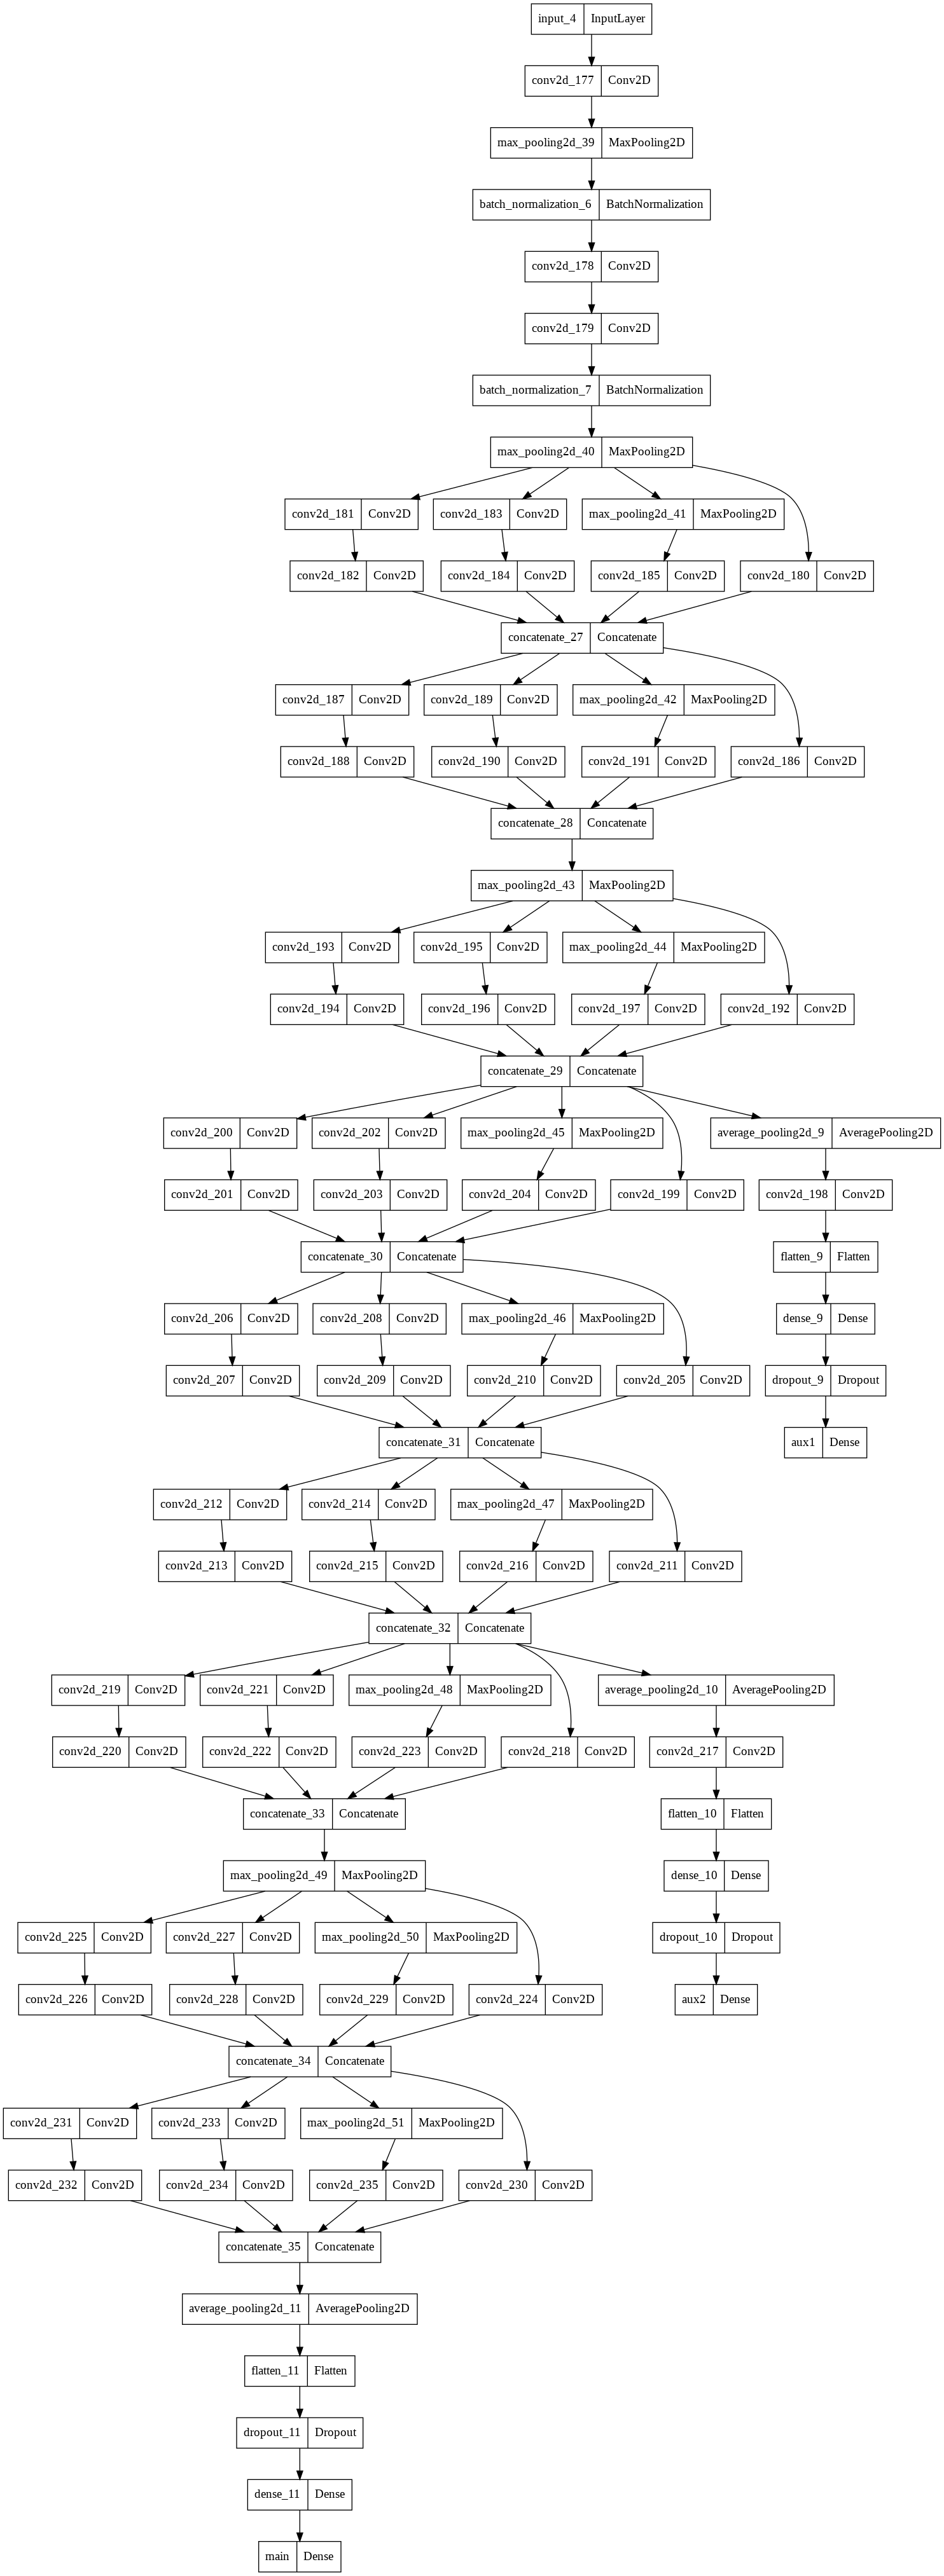

In [ ]:
tf.keras.utils.plot_model(model, 'GoogLeNet.png')

# Training model

## Compile model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_path = "/content/gdrive/MyDrive/Học kỳ 5/Nhập môn thị giác máy tính/Garbage classification/Save_model/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

## Training


In [ ]:
History = model.fit(train_generator,
          validation_data=validation_generator,
          epochs=20,
          verbose=1)

Epoch 1/20
180/180 [==============================] - 57s 290ms/step - loss: 4.7224 - main_loss: 1.5882 - extra1_loss: 1.5602 - extra2_loss: 1.5741 - main_accuracy: 0.3149 - extra1_accuracy: 0.3375 - extra2_accuracy: 0.3222 - val_loss: 4.6201 - val_main_loss: 1.5912 - val_extra1_loss: 1.4776 - val_extra2_loss: 1.5513 - val_main_accuracy: 0.3927 - val_extra1_accuracy: 0.4271 - val_extra2_accuracy: 0.4021
Epoch 2/20
180/180 [==============================] - 50s 279ms/step - loss: 3.6456 - main_loss: 1.2189 - extra1_loss: 1.2052 - extra2_loss: 1.2216 - main_accuracy: 0.5312 - extra1_accuracy: 0.5337 - extra2_accuracy: 0.5264 - val_loss: 4.1295 - val_main_loss: 1.3979 - val_extra1_loss: 1.3342 - val_extra2_loss: 1.3974 - val_main_accuracy: 0.4667 - val_extra1_accuracy: 0.4771 - val_extra2_accuracy: 0.4594
Epoch 3/20
180/180 [==============================] - 52s 286ms/step - loss: 3.3854 - main_loss: 1.1289 - extra1_loss: 1.1225 - extra2_loss: 1.1340 - main_accuracy: 0.5816 - extra1_accur

In [ ]:
model.save('/content/Garbage_Classification_GoogleNet.h5')

In [ ]:
loss = History.history['main_loss']
validation_loss = History.history['val_main_loss']

accuracy = History.history['main_accuracy']
validation_accuracy = History.history['val_main_accuracy']


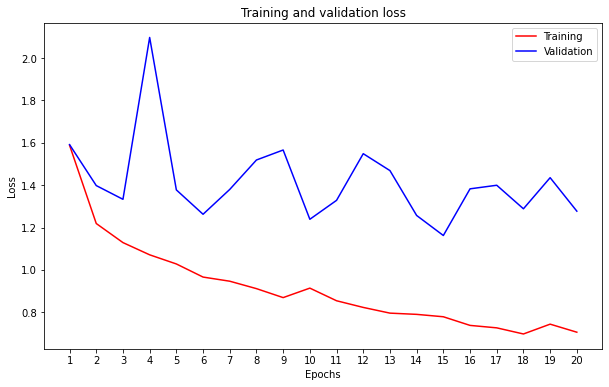

In [ ]:
# plot the training and validation losses
epochs = range(1, len(loss)+1)

fig1 = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,validation_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.title('Training and validation loss')
plt.legend()

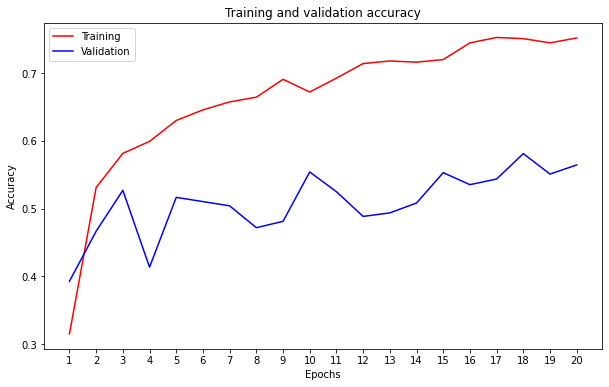

In [ ]:
# plot the training and validation accuracy
epochs = range(1, len(accuracy)+1)

fig2 = plt.figure(figsize=(10,6))
plt.plot(epochs,accuracy,c="red",label="Training")
plt.plot(epochs,validation_accuracy,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.title('Training and validation accuracy')
plt.legend()

# Test

## Function Plot Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# load model
model = keras.models.load_model("/content/gdrive/MyDrive/Học kỳ 5/Nhập môn thị giác máy tính/Garbage classification/Save_model/Googlenet/Garbage_Classification_GoogleNet.h5")

In [ ]:
score = model.evaluate(test_generator)
print("Accuracy of test data: {:.2f}%".format(score[4]*100))

61/61 [==============================] - 6s 93ms/step - loss: 5.3772 - main_loss: 1.8289 - extra1_loss: 1.7541 - extra2_loss: 1.7941 - main_accuracy: 0.4558 - extra1_accuracy: 0.4537 - extra2_accuracy: 0.4631
Accuracy of test data: 45.58%


In [ ]:
Y_pred = model.predict(test_generator, 961 // val_batch_size+1)
y_train_pred = np.argmax(Y_pred[0], axis=1)

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

   cardboard       0.69      0.86      0.77       160
       glass       0.74      0.45      0.56       161
       metal       0.30      0.52      0.38       159
       paper       0.61      0.29      0.39       160
     plastic       0.32      0.38      0.35       160
       trash       0.30      0.24      0.27       161

    accuracy                           0.46       961
   macro avg       0.49      0.46      0.45       961
weighted avg       0.50      0.46      0.45       961



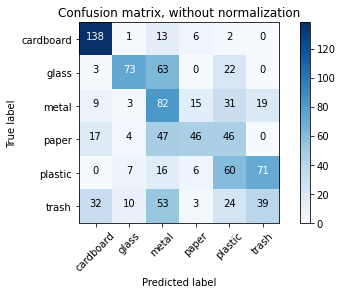

In [ ]:
print('Confusion Matrix')
cnf_matrix = confusion_matrix(test_generator.classes, y_train_pred)

labels = sorted(os.listdir('/content/Garbage classification/test'))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix, without normalization')

print('Classification Report')
print(classification_report(test_generator.classes, y_train_pred, target_names=labels, zero_division=1))